In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import json
import shutil
import cv2
import tensorflow as tf
import tensorflow.keras as keras

from PIL import Image
from glob import glob
from tensorflow.keras import applications
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import losses
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing import image

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
BASE_PATH = os.path.join("\\".join(dirc for dirc in os.getcwd().split("\\")[:-1]))
BASE_PATH

'C:\\Users\\Scooby Doo\\Projects\\malaria_detection'

In [4]:
DATA_PATH = os.path.join(BASE_PATH, "data")
DATA_PATH

'C:\\Users\\Scooby Doo\\Projects\\malaria_detection\\data'

### Now download dataset from kaggle
https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria

In [5]:
dirnames = sorted([dirname for dirname in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, dirname))])
dirnames

['Parasitized', 'Uninfected']

In [6]:
os.mkdir(os.path.join(DATA_PATH, "train"))
os.mkdir(os.path.join(DATA_PATH, "valid"))

In [7]:
for dirname in dirnames:
    shutil.move(os.path.join(DATA_PATH, dirname), os.path.join(DATA_PATH, "train", dirname))

In [8]:
records = [(os.path.join(DATA_PATH, "train", dirname, filename), dirname) for dirname in dirnames for filename in os.listdir(os.path.join(DATA_PATH, "train", dirname)) if filename.endswith('.png')]

df = pd.DataFrame(records, columns=["image", "category"])
df.head()

,image,category
0,C:\Users\Scooby Doo\Projects\malaria_detection...,Parasitized
1,C:\Users\Scooby Doo\Projects\malaria_detection...,Parasitized
2,C:\Users\Scooby Doo\Projects\malaria_detection...,Parasitized
3,C:\Users\Scooby Doo\Projects\malaria_detection...,Parasitized
4,C:\Users\Scooby Doo\Projects\malaria_detection...,Parasitized


In [9]:
df.image[0]

'C:\\Users\\Scooby Doo\\Projects\\malaria_detection\\data\\train\\Parasitized\\C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [10]:
# Now check class balance
df.category.value_counts()

Parasitized    13779
Uninfected     13779
Name: category, dtype: int64

In [11]:
categories = list(df.category.unique())
categories

['Parasitized', 'Uninfected']

In [12]:
len(os.listdir(os.path.join(DATA_PATH, "train", "Parasitized")))

13780

In [13]:
len(os.listdir(os.path.join(DATA_PATH, "train", "Uninfected")))

13780

In [14]:
# Lets create validation data from train data
for category in categories:
    category_valid = glob(os.path.join(DATA_PATH, "train", category, "*.png"))
    shuf = np.random.permutation(category_valid)

    os.mkdir(os.path.join(DATA_PATH, "valid", category))
    for i in range(int(len(category_valid) / 4)): shutil.move(shuf[i], os.path.join(DATA_PATH, "valid", category))

In [15]:
len(os.listdir(os.path.join(DATA_PATH, "valid", "Parasitized")))

3444

In [16]:
len(os.listdir(os.path.join(DATA_PATH, "valid", "Uninfected")))

3444

In [17]:
def display_images(path, color_channel=3, width=100, height=100, number_images=5):
    image_names = os.listdir(path)
    random.shuffle(image_names)
    image_array = np.empty((number_images, width, height, color_channel))
    
    plt.clf()
    fig, axs = plt.subplots(1, number_images, figsize=(25, number_images))
    
    for i, ax, record in zip(range(number_images), axs, image_names[:number_images]):
        img = cv2.imread(os.path.join(path, record))
        img = cv2.resize(img, (width, height))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image_array[i] = img
        
        ax.set_title(path.split("\\")[-1])
        ax.imshow(img)

    plt.show()

<Figure size 432x288 with 0 Axes>

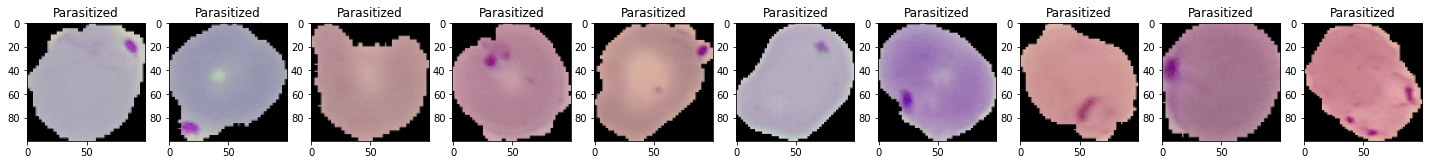

<Figure size 432x288 with 0 Axes>

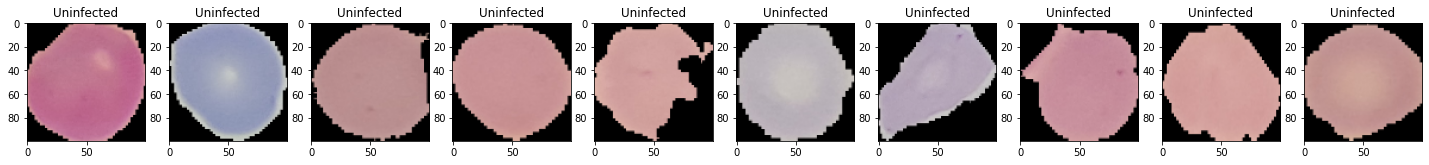

In [18]:
# Let see few images from each train category
for category in categories:
    display_images(path=os.path.join(DATA_PATH, "train", category), number_images=10)

<Figure size 432x288 with 0 Axes>

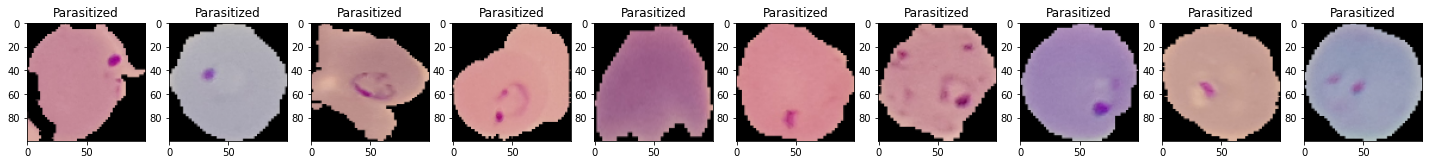

<Figure size 432x288 with 0 Axes>

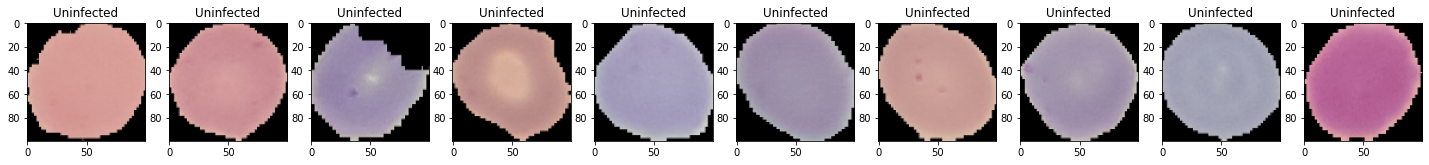

In [19]:
# Let see few images from each valid category
for category in categories:
    display_images(path=os.path.join(DATA_PATH, "valid", category), number_images=10)

In [20]:
batch_size = 150
datagen = image.ImageDataGenerator()
train_datagen = datagen.flow_from_directory(os.path.join(DATA_PATH, "train"), target_size=(110, 110), class_mode="categorical", shuffle=True, batch_size=batch_size)
valid_datagen = datagen.flow_from_directory(os.path.join(DATA_PATH, "valid"), target_size=(110, 110), class_mode="categorical", shuffle=True, batch_size=batch_size)

Found 20670 images belonging to 2 classes.
Found 6888 images belonging to 2 classes.


In [21]:
X_input = Input((110, 110, 3))

# Zero-Padding: pads the border of X_input with zeroes
X = layers.ZeroPadding2D((3, 3))(X_input)

# CONV -> BN -> RELU Block applied to X
X = layers.Conv2D(32, (7, 7), strides=(1, 1), name="conv0")(X)
X = layers.BatchNormalization(axis=3, name="bn0")(X)
X = layers.Activation("relu")(X)

# MORE CONVS
X = layers.MaxPooling2D((2, 2))(X)
#shortcut = X
X = layers.Conv2D(32, (3, 3), strides=(1, 1), padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation("relu")(X)
X = layers.Conv2D(32, (3, 3), strides=(1, 1), padding="same")(X)
X = layers.BatchNormalization()(X)
#X = layers.add([X, shortcut])
X = layers.Activation("relu")(X)

# MAXPOOL
X = layers.MaxPooling2D((2, 2), name="max_pool")(X)

# FLATTEN X (means convert it to a vector) + FULLYCONNECTED
X = layers.Flatten()(X)

# MORE DENSE
X = layers.Dense(128)(X)
X = layers.BatchNormalization()(X)
X = layers.Activation("relu")(X)
X = layers.Dropout(0.5)(X)

X_output = layers.Dense(2, activation="softmax", name="fc")(X)

# Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
model = Model(inputs = X_input, outputs = X_output, name="HappyModel")
model.compile(optimizers.Adam(lr=0.0001), "categorical_crossentropy", ["accuracy"])

In [22]:
model.summary()

Model: "HappyModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 110, 110, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 116, 116, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 110, 110, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 110, 110, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 110, 110, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 55, 55, 32)        9

In [23]:
callback = keras.callbacks.ModelCheckpoint(os.path.join(BASE_PATH, "weights", "best_malaria.h5"), monitor="val_accuracy", verbose=1, 
                                           save_weights_only=True, save_best_only=True, mode="max")

In [24]:
if os.path.isfile(os.path.join(BASE_PATH, "weights", "best_malaria.h5")):
    model.load_weights(os.path.join(BASE_PATH, "weights", "best_malaria.h5"))

In [25]:
history = model.fit_generator(train_datagen, epochs=50, validation_data=valid_datagen, callbacks=[callback])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
138/138 [==============================] - ETA: 0s - loss: 0.6349 - accuracy: 0.6983
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to C:\Users\Scooby Doo\Projects\malaria_detection\weights\best_malaria.h5
138/138 [==============================] - 30s 215ms/step - loss: 0.6349 - accuracy: 0.6983 - val_loss: 2.7338 - val_accuracy: 0.5000
Epoch 2/50
138/138 [==============================] - ETA: 0s - loss: 0.3555 - accuracy: 0.8439
Epoch 00002: val_accuracy improved from 0.50000 to 0.63487, saving model to C:\Users\Scooby Doo\Projects\malaria_detection\weights\best_malaria.h5
138/138 [==============================] - 27s 193ms/step - loss: 0.3555 - accuracy: 0.8439 - val_loss: 0.7782 - val_accuracy: 0.6349
Epoch 3/50
138/138 [==============================] - ETA: 0s - loss: 0.2150 - accuracy: 0.9161
Epoch 00003: val_accuracy improved from 0.63487 to 0.85206, saving model to C

Epoch 27/50
138/138 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9977
Epoch 00027: val_accuracy did not improve from 0.93917
138/138 [==============================] - 31s 224ms/step - loss: 0.0117 - accuracy: 0.9977 - val_loss: 0.4547 - val_accuracy: 0.9021
Epoch 28/50
138/138 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 0.9977
Epoch 00028: val_accuracy did not improve from 0.93917
138/138 [==============================] - 29s 211ms/step - loss: 0.0111 - accuracy: 0.9977 - val_loss: 0.6283 - val_accuracy: 0.8069
Epoch 29/50
138/138 [==============================] - ETA: 0s - loss: 0.0079 - accuracy: 0.9989
Epoch 00029: val_accuracy improved from 0.93917 to 0.94178, saving model to C:\Users\Scooby Doo\Projects\malaria_detection\weights\best_malaria.h5
138/138 [==============================] - 30s 218ms/step - loss: 0.0079 - accuracy: 0.9989 - val_loss: 0.2225 - val_accuracy: 0.9418
Epoch 30/50
138/138 [=============================

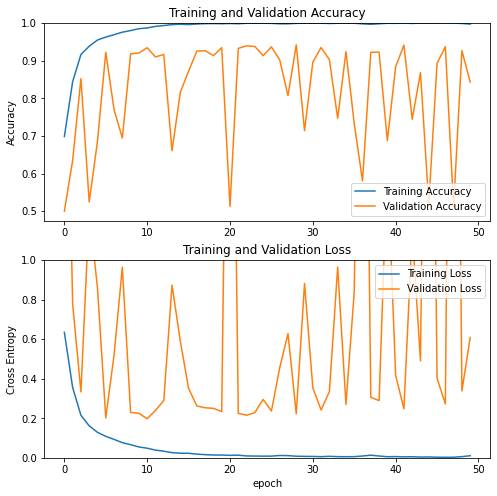

In [26]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()),1])
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.ylim([0,1.0])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

model.load_weights(os.path.join(BASE_PATH, "weights", "best_malaria.h5"))
Y_pred = model.predict_generator(valid_datagen)
y_pred = np.argmax(Y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(valid_datagen.classes, y_pred))

Instructions for updating:
Please use Model.predict, which supports generators.
Confusion Matrix
[[1741 1703]
 [1708 1736]]


In [29]:
version=1
tf.keras.models.save_model(model, os.path.join(BASE_PATH, "serving/tf_serving", str(version)), overwrite=True, include_optimizer=True, save_format=None,
                        signatures=None, options=None)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\Scooby Doo\Projects\malaria_detection\serving/tf_serving\1\assets


### Testing using loading model weights

In [32]:
img = cv2.imread(os.path.join(DATA_PATH, "train", "Parasitized", "C33P1thinF_IMG_20150619_114756a_cell_179.png"))
img = cv2.resize(img, (110, 110))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.reshape(img, (1, 110, 110, 3))
model.predict(img)

array([[9.9999869e-01, 1.2594031e-06]], dtype=float32)

### Testing using TF Serving

In [33]:
import json
import requests

headers = {"Content-Type": "application/json"}
payloads = {"signature_name": "serving_default", "inputs": {"input_1": img.tolist()}}
tfserving_response = requests.post("http://localhost:8501/v1/models/malaria:predict", headers=headers, data=json.dumps(payloads)).json()
(tfserving_response)

{'outputs': [[1.0, 5.95263643e-08]]}